In [1]:
import torch
import numpy as np
import sys
import matplotlib.pyplot as plt
from utils import checkpoint, warning
import utils
import MCHMC, MCLMC
import autotuning as aut
import integration_schemes as integ
import functions as funct
import visualization as vis
import importlib

In [2]:
# questo serve altrimenti non usa l'ultima versione dei file .py
importlib.reload(utils)
importlib.reload(MCHMC)
importlib.reload(MCLMC)
importlib.reload(aut)
importlib.reload(integ)
importlib.reload(funct)
importlib.reload(vis)

<module 'visualization' from '/home/ubuntu/MCHMC/visualization.py'>

# Information Theory Project

Allora da quel che mi sembra aver capito, per fare il tuning di L loro usano $n_{eff}^{(i)}$, che calcolano tramite l'autocorrelazione $n_{eff} = \frac{N}{1+2\sum_{t=1}^{\inf}\rho_t}$. Dato che il rumore nella stima delle autocorrelazioni aumenta con t, di solito si tronca la somma per non avere $n_{eff}^{(i)}$ negativi. C'è da sistemare il calcolo seguendo per esempio https://mc-stan.org/docs/reference-manual/analysis.html#effective-sample-size.section .

Quando invece calcolano ESS come metrica per confrontare i diversi algoritmi, lì usano la nozione di $n_{eff}$ legata a $b_2$, ovvero $b_2^2 = 2/n_{eff}$. Settando come target $b_2=0.1$ definiscono $ESS = 200/n$, con n il numero di tagret density evaluation per raggiungere quel valore di $b_2$. Quindi credo che l'idea sarebbe di runnare l'algoritmo non con un numero predefinito di step fino a quando non raggiunge questo threshold.

Miei personalissimi **dubbi**:
- Con target density evaluations non intendono il numero di run teoricamente, ma quante volte viene calcolato il gradiente di L che è la cosa computazionalmente più impegnativa. Dipenderebbe quindi dall'integration scheme: con LF 2 per run, mentre con MN 3 (ogni volta che facciamo update del momento calcoliamo $\nabla L$). Ha senso?
- Nella tabella dove riportano le ESS non mi tornano bene i conti. Esempio: per la Bimodal nel caso migliore abbiamo ESS=0.064 e quindi avremmo n=3125. Non ha senso questa cosa, quando loro stessi scrivono che impiegano $10^7$ runs. Sono confusa.

Cose da **fare**:
- Sistemare calcolo di $n_{eff}^{(i)}$ (*utils.effective_sample_size*)
- Calcolare ESS per confronto algoritmi (tabella che ci interessa)
- Implementare altre funzioni, abbiamo solo bimodal e cauchy (che io direi di lasciare perdere dato che è incasinata)
- Implementare NUTS con NumPyro/PyMC

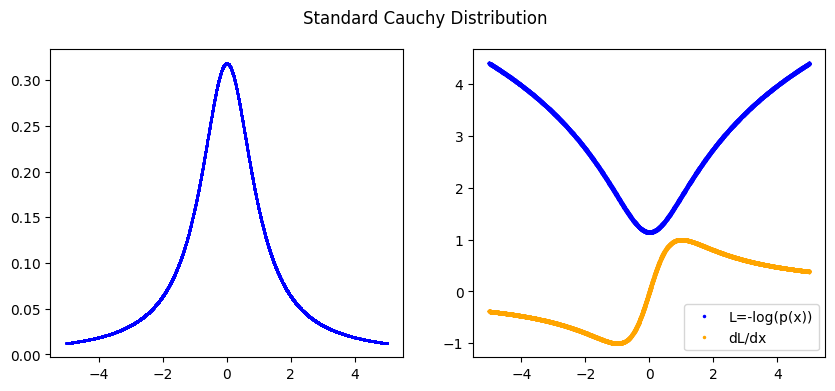

In [3]:
x = np.random.uniform(low=-5, high=5, size=(10000, 1))
L = -np.log(funct.standard_cauchy(x).detach().numpy())
nablaL = integ.grad_log_likelihood(x, funct.standard_cauchy).numpy()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].plot(x, funct.standard_cauchy(x).numpy(), 'o', c='blue', ms=1)

axes[1].plot(x, L, 'o', color='blue', markersize=1.5, label='L=-log(p(x))')
axes[1].plot(x, nablaL, 'o', color='orange', markersize=1.5, label='dL/dx')
axes[1].legend()

fig.suptitle('Standard Cauchy Distribution')
plt.show()

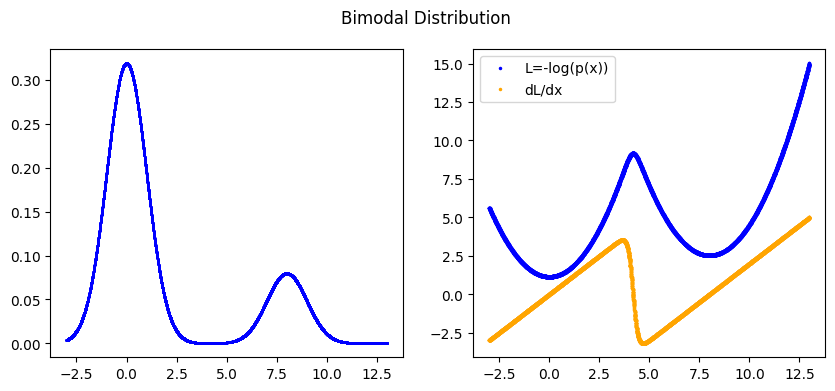

In [13]:
x = np.random.uniform(low=-3, high=13, size=(10000, 1))
L = -np.log(funct.bimodal(x).to("cpu").detach().numpy())
nablaL = integ.grad_log_likelihood(x, funct.bimodal).numpy()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].plot(x, funct.bimodal(x).to("cpu").numpy(), 'o', c='blue', ms=1)

axes[1].plot(x, L, 'o', color='blue', markersize=1.5, label='L=-log(p(x))')
axes[1].plot(x, nablaL, 'o', color='orange', markersize=1.5, label='dL/dx')
axes[1].legend()

fig.suptitle('Bimodal Distribution')
plt.show()

<span style="color:red;">Le due gaussiane dovevano essere separate di $8\sigma$, io avevo deliberatamente scelto per semplicità di separarle solo nella prima direzione. Forse sarebbe più saggio imporre che la distanza tra le due mode sia di $8\sigma$ nello spazio d-dimensionale per avere una situazione più generale. Alla fine lìho fatto ma non saprei bene come rappresentare i risultati finali.</span>

## Microcanonical Hamiltonian Montecarlo

Let's start with the tuning of $\epsilon$ and L for the bimodal function, it should converge (ma loro hanno fatto $10^7$ steps).

In [5]:
# Optimizing epsilon
eps_values, sigma_effs = aut.tune_eps(d=100, N=300, L=10, fn=funct.bimodal, algorithm=MCHMC.MCHMC_bounces, iterations=5)

epsilon_opt = eps_values.mean()
sigma_eff = sigma_effs.mean()
print(f'Optimal epsilon: {epsilon_opt}')


Running 5 iterations of <function MCHMC_bounces at 0x7fcc9968cdc0> with 300 steps, updating epsilon


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 124.18it/s]

Optimal epsilon: 0.8351564407348633


In [6]:
L_values = aut.tune_L(sigma_eff, epsilon_opt, d=100, N=300, fn=funct.bimodal, algorithm=MCHMC.MCHMC_bounces, iterations=5)

L_opt = L_values.mean()
print(f'Optimal L: {L_opt}')


Running 5 iterations of <function MCHMC_bounces at 0x7fcc9968cdc0> with 300 steps, updating L


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 123.32it/s]


Optimal L: 3.3276991844177246


<span style="color:red;"> Qui c'è il problema di L negativo, che non ha senso. Da sistemare il calcolo di $n_{eff}^{(i)}$. </span>

In [22]:
X, *_ = MCHMC.MCHMC_bounces(d=100, N=10000, L=20, epsilon=epsilon_opt, fn=funct.bimodal)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:22<00:00, 121.64it/s]


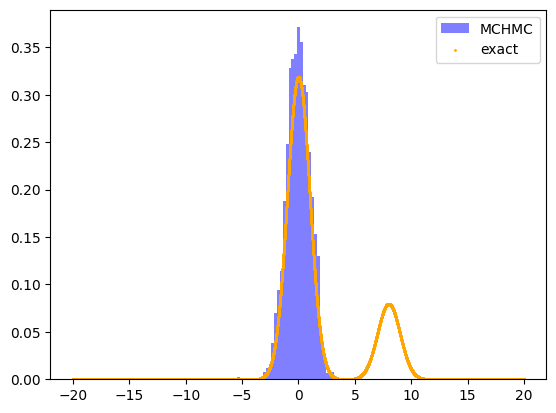

In [23]:
X = X.to("cpu").detach().numpy()
x = np.linspace(-20, 20, 10000)
plt.hist(X[:,0], density=True, alpha=0.5, bins=50, color='blue', label='MCHMC')
plt.scatter(x, funct.bimodal(x).to("cpu").numpy(), color='orange', s=1, label='exact')
plt.legend()
plt.show()

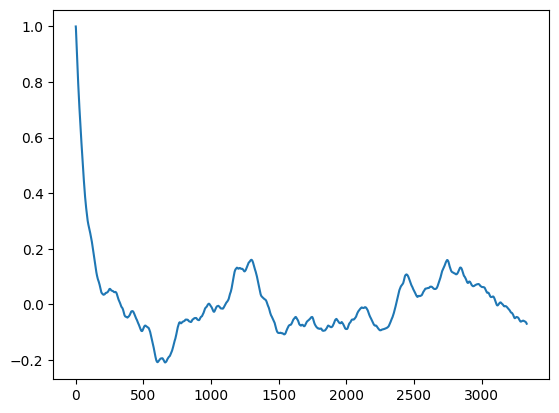

In [18]:
import statsmodels.api as sm
N=10000
nlags = int(N/3)

x_i = X[:,99]
ac = sm.tsa.acf(x_i, fft=True, nlags=nlags)

plt.plot(range(nlags+1), ac)

## Langevin-like Hamiltonian Montecarlo

In [14]:
# Optimizing epsilon
L = torch.tensor(10, device=utils.choose_device())
eps_values, sigma_effs = aut.tune_eps(d=1000, N=300, L=L, fn=funct.bimodal, algorithm=MCLMC.MCLMC, iterations=5)

epsilon_opt = eps_values.mean()
sigma_eff = sigma_effs.mean()
print(f'Optimal epsilon: {epsilon_opt}')


Running 5 iterations of <function MCLMC at 0x7fb3e103e170> with 300 steps, updating epsilon


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 118.97it/s]

Optimal epsilon: 8.252389907836914


In [15]:
L_values = aut.tune_L(sigma_eff, epsilon_opt, d=1000, N=300, fn=funct.bimodal, algorithm=MCLMC.MCLMC, iterations=5, debug=False, cauchy=False)

L_opt = L_values.mean()
print(f'Optimal L: {L_opt}')


Running 5 iterations of <function MCLMC at 0x7fb3e103e170> with 300 steps, updating L


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 116.89it/s]


Optimal L: 6.798242092132568


In [16]:
X, *_ = MCLMC.MCLMC(d=1000, N=10000, L=L_opt, epsilon=epsilon_opt, fn=funct.bimodal)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:26<00:00, 115.67it/s]


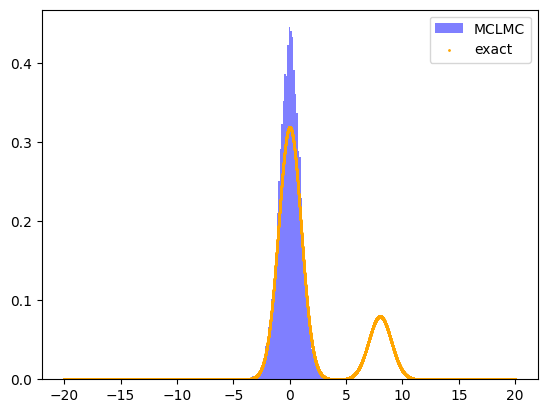

In [24]:
X = X.to("cpu").detach().numpy()

'''
d=1000
mu1 = np.zeros(d)
mu2 = np.full((d,), 8.0 / np.sqrt(d))
separation_axis = mu1-mu2
u = separation_axis / np.norm(separation_axis)
X_proj = samples @ unit_vec
'''

x = np.linspace(-20, 20, 10000)
plt.hist(X[:,0], density=True, alpha=0.5, bins=50, color='blue', label='MCLMC')
plt.scatter(x, funct.bimodal(x).to("cpu").numpy(), color='orange', s=1, label='exact')
plt.legend()
plt.show()

In [25]:
# Optimizing epsilon
L = torch.tensor(10, device=utils.choose_device())
eps_values, sigma_effs = aut.tune_eps(d=2, N=300, L=L, fn=funct.bimodal, algorithm=MCLMC.MCLMC, iterations=5)

epsilon_opt = eps_values.mean()
sigma_eff = sigma_effs.mean()
print(f'Optimal epsilon: {epsilon_opt}')

L_values = aut.tune_L(sigma_eff, epsilon_opt, d=1000, N=300, fn=funct.bimodal, algorithm=MCLMC.MCLMC, iterations=5, debug=False, cauchy=False)

L_opt = L_values.mean()
print(f'Optimal L: {L_opt}')


Running 5 iterations of <function MCLMC at 0x7fb3e103e170> with 300 steps, updating epsilon


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 120.53it/s]


Optimal epsilon: 0.6913236975669861

Running 5 iterations of <function MCLMC at 0x7fb3e103e170> with 300 steps, updating L


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 113.77it/s]


Optimal L: 19.449201583862305


100%|█████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:26<00:00, 115.50it/s]


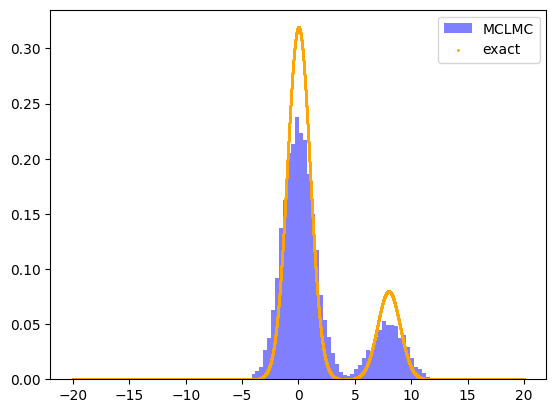

In [26]:
X, *_ = MCLMC.MCLMC(d=2, N=10000, L=L_opt, epsilon=epsilon_opt, fn=funct.bimodal)

X = X.to("cpu").detach().numpy()
x = np.linspace(-20, 20, 10000)
plt.hist(X[:,0], density=True, alpha=0.5, bins=50, color='blue', label='MCLMC')
plt.scatter(x, funct.bimodal(x).to("cpu").numpy(), color='orange', s=1, label='exact')
plt.legend()
plt.show()